In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

file_red = 'data/winequality-red.csv'
file_white = 'data/winequality-white.csv'

df_red = pd.read_csv(file_red, delimiter=';')
df_red['wine_type'] = 'red'

df_white = pd.read_csv(file_white, delimiter=';')
df_white['wine_type'] = 'white'

wine_variant = 'both'  # 'red', 'white', or 'both'

if wine_variant == 'red':
    df = df_red.copy()
elif wine_variant == 'white':
    df = df_white.copy()
else:
    df = pd.concat([df_red, df_white], ignore_index=True)

df['wine_type'] = df['wine_type'].map({'red': 0, 'white': 1})

df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


In [63]:
# Check for missing values
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_type               0
dtype: int64

In [64]:
# Check data types
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
wine_type                 int64
dtype: object

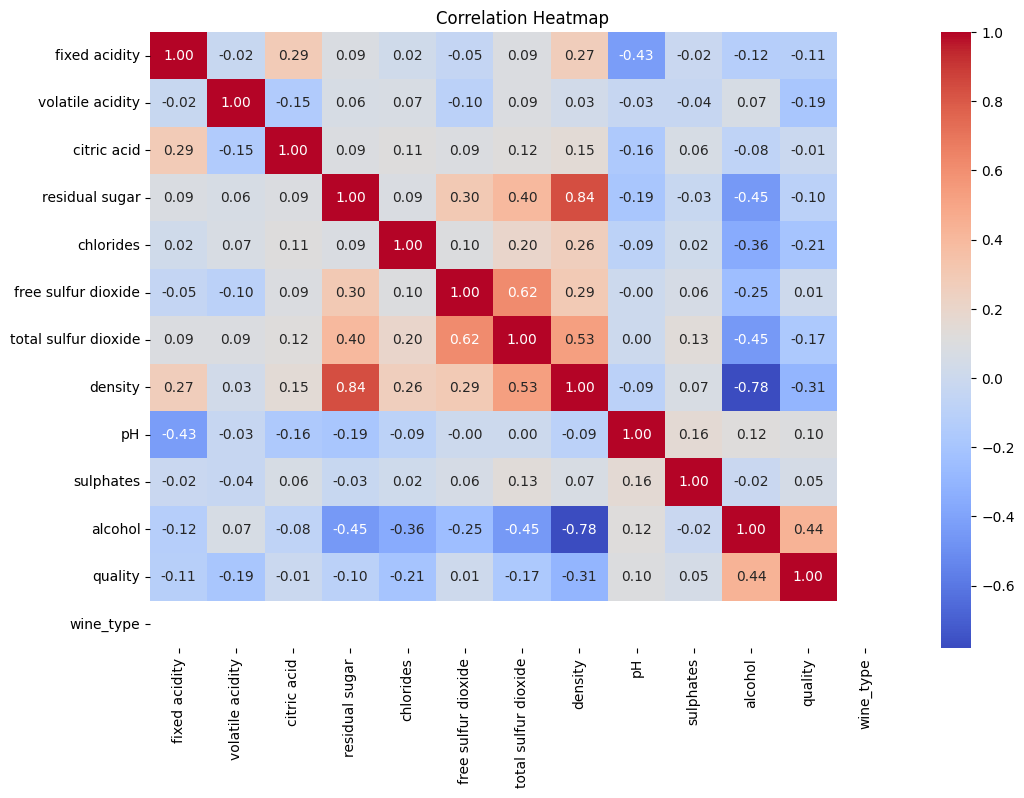

In [65]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

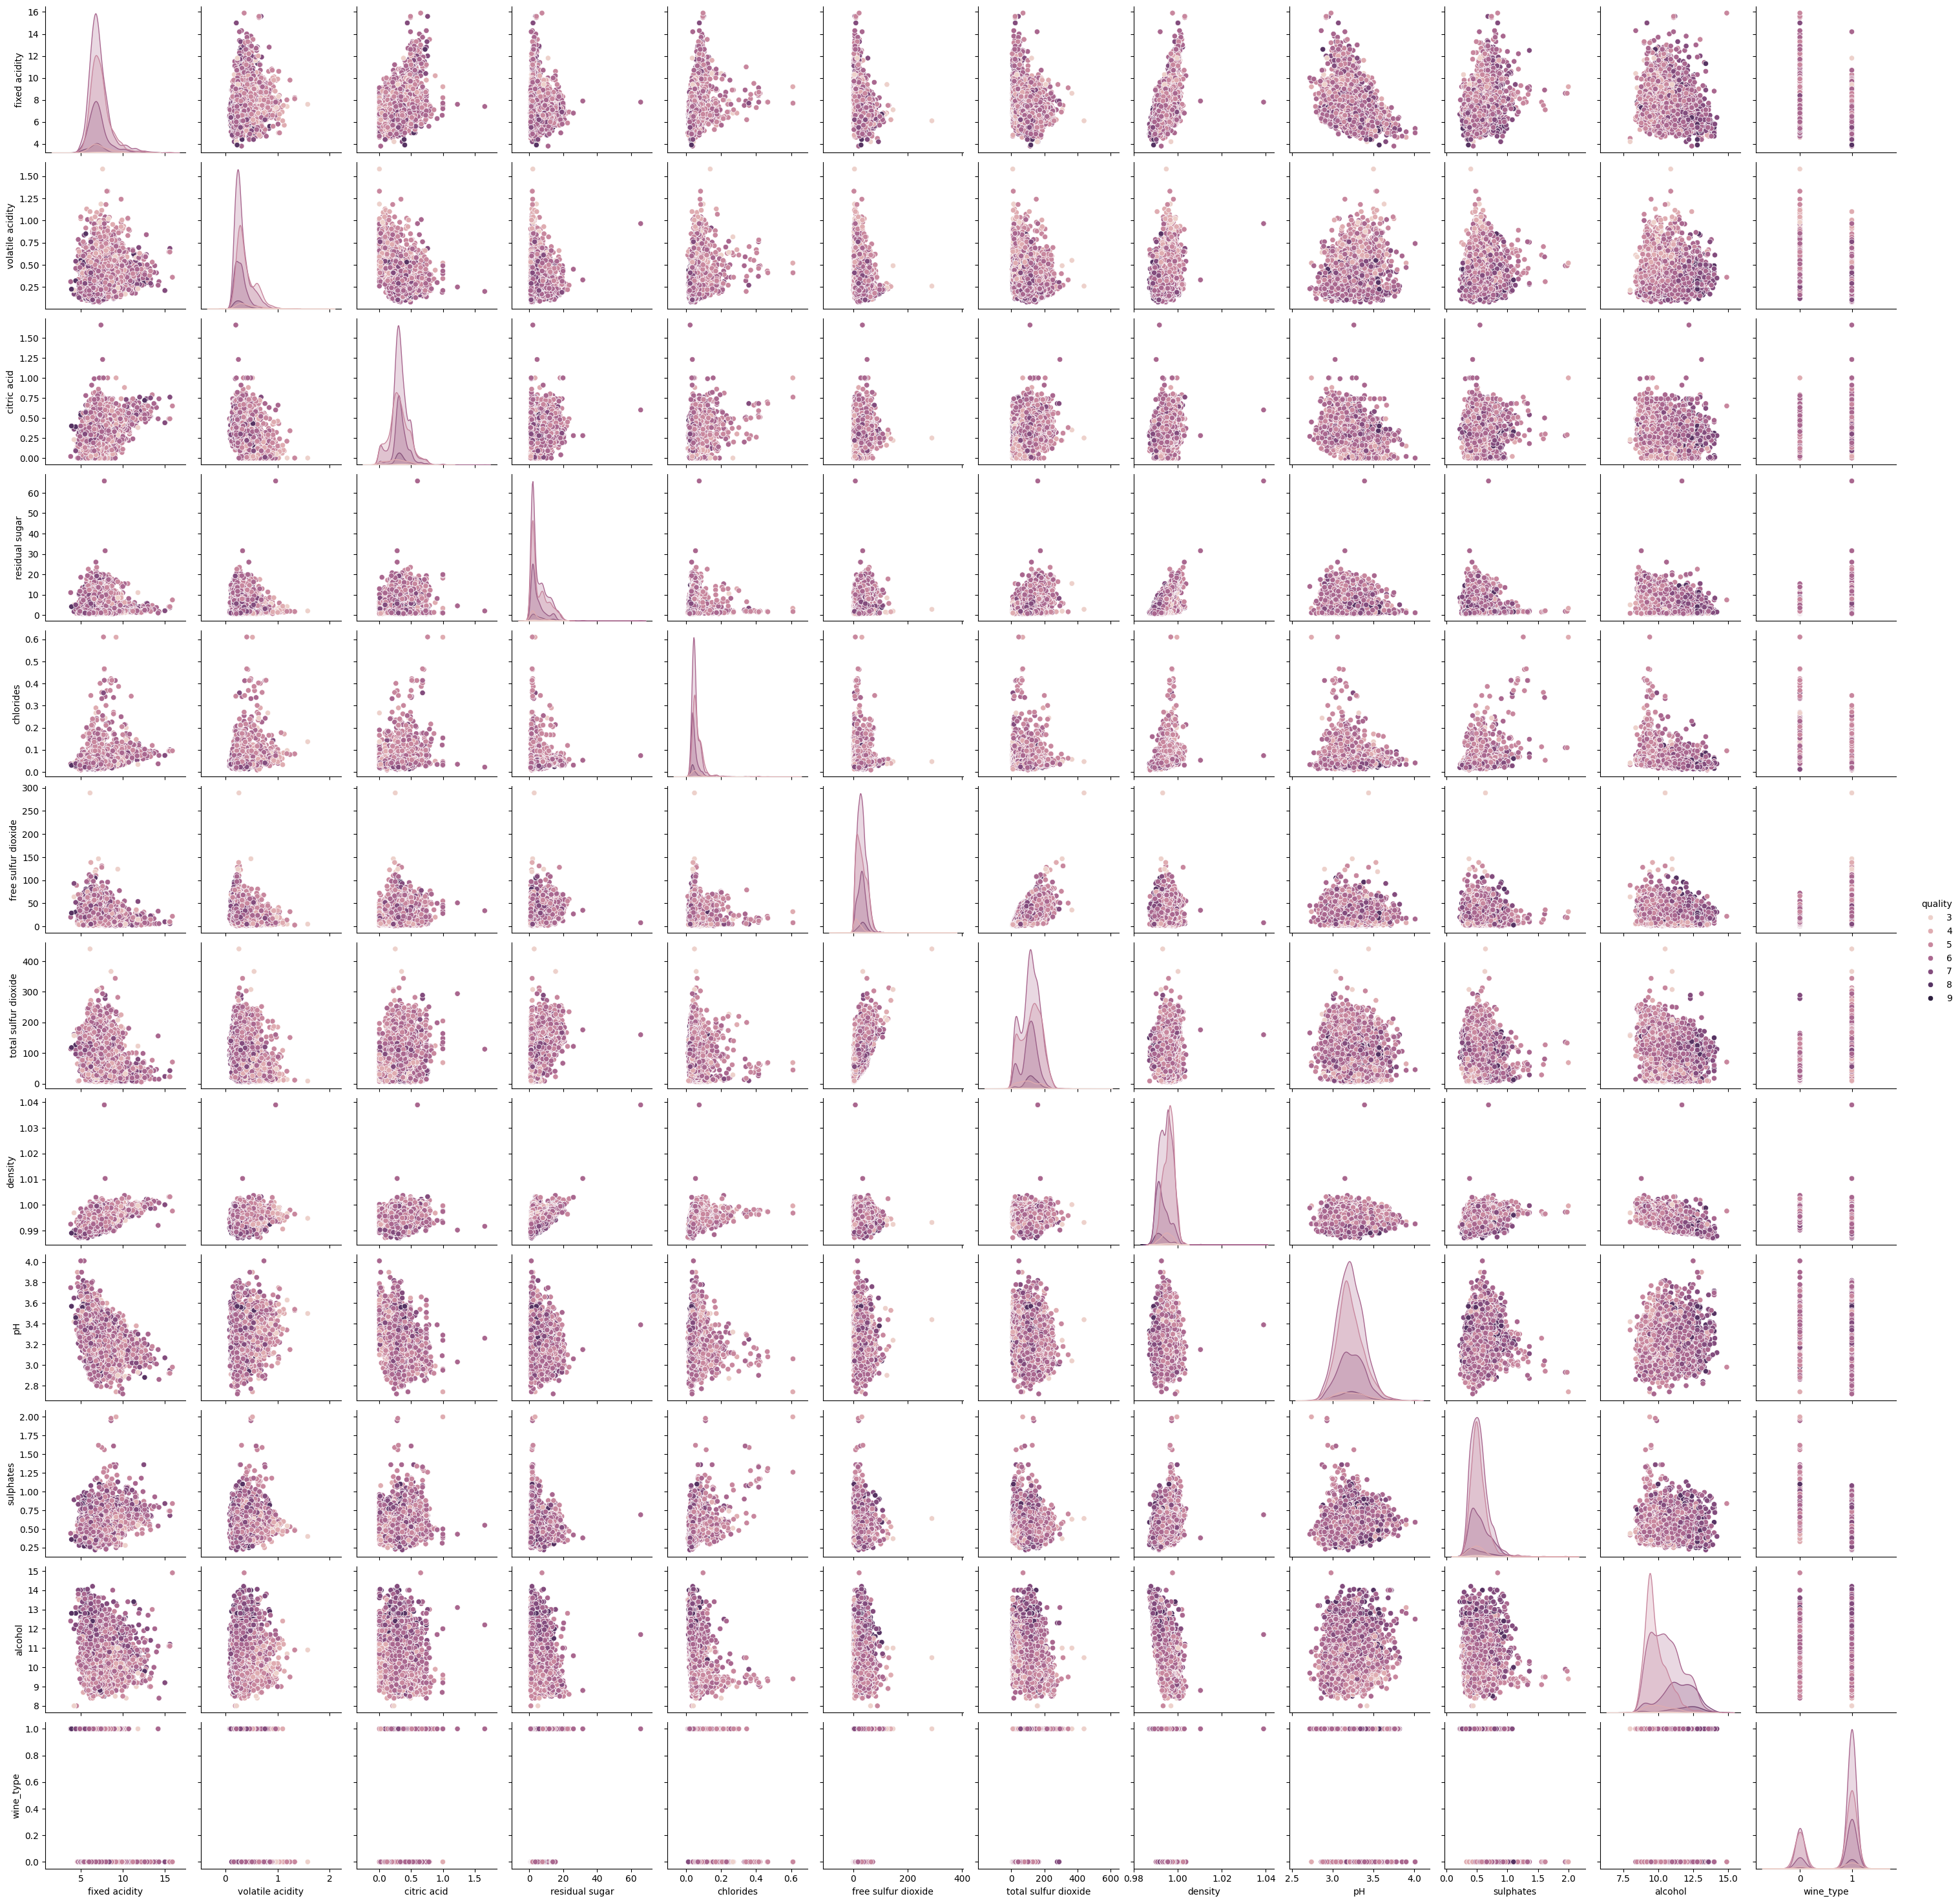

In [5]:
# Pair plot
sns.pairplot(df, hue='quality')
plt.show()

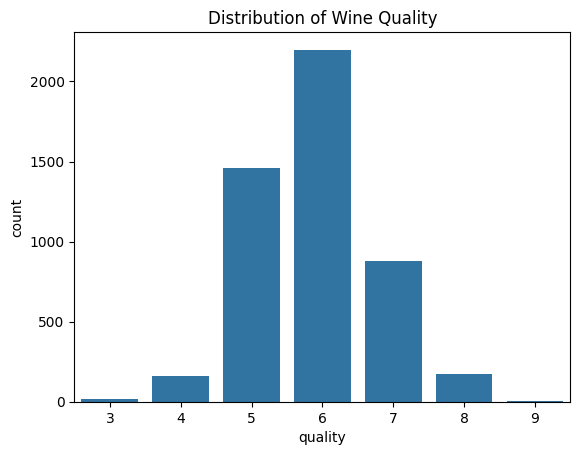

In [66]:
# Distribution of wine quality
sns.countplot(x='quality', data=df)
plt.title('Distribution of Wine Quality')
plt.show() 

In [67]:
# Creating a new feature based on acidity levels
df['acidity_level'] = pd.cut(df['fixed acidity'], bins=[0, 7, 14], labels=['low', 'high'])
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,acidity_level
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1,low
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1,low
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1,high
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,high
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,high


In [68]:
# Convert categorical features to numeric
df['acidity_level'] = df['acidity_level'].cat.codes

# Split the data into training and testing sets
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

def tolerance_accuracy(y_true, y_pred, tolerance=1):
    return np.mean(np.abs(y_true - y_pred) <= tolerance)    

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(tolerance_accuracy(y_test, y_pred))




              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.71      0.20      0.31        25
           5       0.72      0.72      0.72       291
           6       0.67      0.79      0.72       432
           7       0.74      0.59      0.66       192
           8       0.88      0.43      0.58        35

    accuracy                           0.70       980
   macro avg       0.62      0.45      0.50       980
weighted avg       0.70      0.70      0.69       980

0.9663265306122449


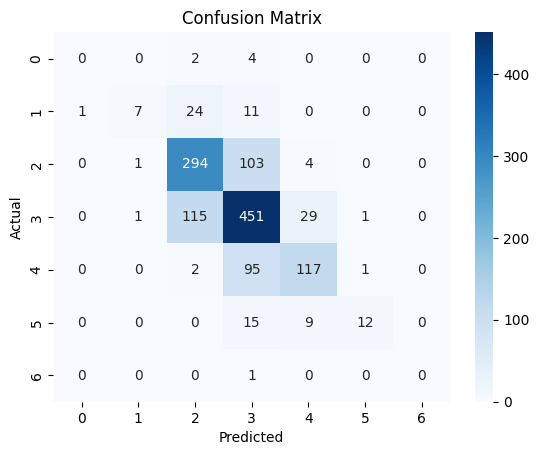

In [25]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

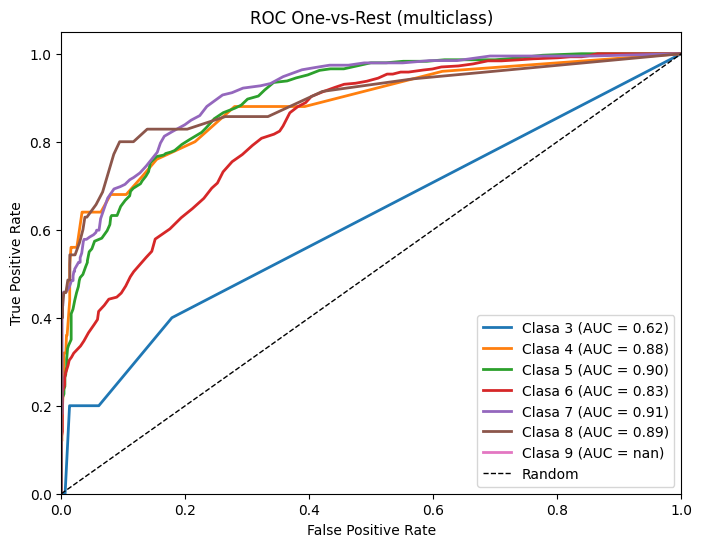

In [ ]:
# ROC Curves (one-vs-rest)
y_prob = model.predict_proba(X_test)
classes = list(model.classes_)
plt.figure(figsize=(8, 6))
for idx, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test == cls, y_prob[:, idx])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clasa {cls} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC One-vs-Rest (multiclass)')
plt.legend(loc='lower right')
plt.show()

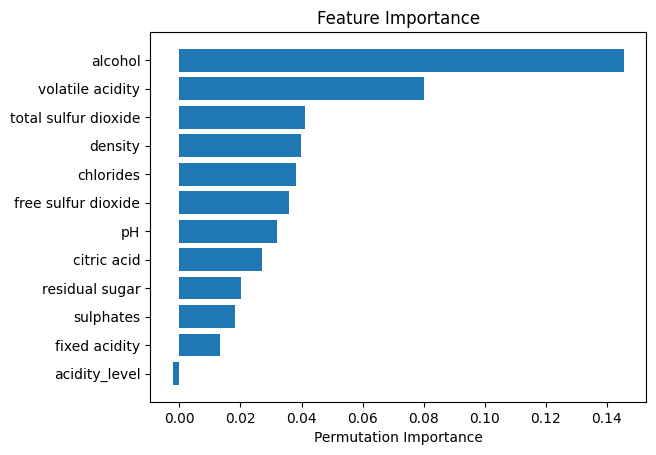

In [11]:
# Permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()